# AutoEncoding collective variables

### Import

In [1]:
# IMPORT PACKAGES
import torch
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcvs.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Muller-Brown potential (high-temperature)

### Load MD data

In [2]:
from mlcvs.utils.io import create_dataset_from_files
from mlcvs.data import DictionaryDataModule

filenames = [ "data/muller-brown/unbiased/high-temp/COLVAR" ]

# load data into dataset
dataset, df = create_dataset_from_files(filenames,filter_args={'regex':'p.x|p.y'},return_dataframe=True)

# create datamodule
datamodule = DictionaryDataModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (5001, 11)

 - Loaded dataframe (5001, 11): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2']
 - Descriptors (5001, 2): ['p.x', 'p.y']


<AxesSubplot:xlabel='p.x', ylabel='p.y'>

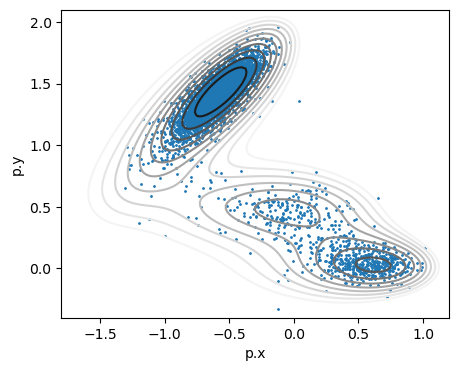

In [3]:
fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',s=1,cmap='fessa',ax=ax)

### Define model

In [ ]:
from mlcvs.cvs import AutoEncoder_CV

n_components = 1
encoder_layers = [2,10,10,n_components]
nn_args = {'activation': 'shifted_softplus'}
options= {'encoder': nn_args, 'decoder': nn_args }

model = AutoEncoder_CV (encoder_layers, options=options )
model

VAE

In [34]:
from mlcvs.cvs import VAE_CV

n_components = 1
encoder_layers = [2,10,10]
decoder_layers = [2]
nn_args = {'activation': 'elu'}
options= {'encoder': nn_args, 'decoder': nn_args }

model = VAE_CV(n_cvs = n_components, encoder_layers = encoder_layers, decoder_layers= decoder_layers, options=options )
model

VAE_CV(
  (normIn): Normalization(in_features=2, out_features=2, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ELU(alpha=True)
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): ELU(alpha=True)
      (4): Linear(in_features=10, out_features=2, bias=True)
    )
  )
  (decoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=1, out_features=2, bias=True)
    )
  )
)

### Define Trainer & Fit

In [35]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from mlcvs.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-5, patience=10)

# define trainer
trainer = pl.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | normIn  | Normalization | 0      | [2]      | [2]      
1 | encoder | FeedForward   | 162    | [2]      | [2]      
2 | decoder | FeedForward   | 4      | ?        | ?      

Epoch 355: 100%|██████████| 2/2 [00:00<00:00, 189.49it/s, loss=0.139]       


Learning curve

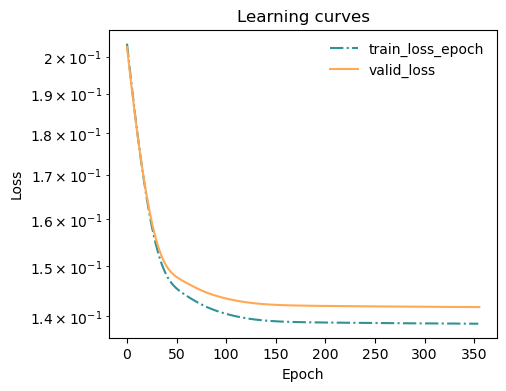

In [36]:
model.eval()

ax = plot_metrics(metrics.metrics, 
                  keys=['train_loss_epoch','valid_loss'],
                  linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='log')


Normalize output after training

In [38]:
from mlcvs.core.transform import Normalization
from mlcvs.core.transform.utils import Statistics

X = dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset  
    s = model(torch.Tensor(X))

norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) ) 
model.postprocessing = norm
#print(Statistics(s))

### Analysis of the CV

CVs isolines

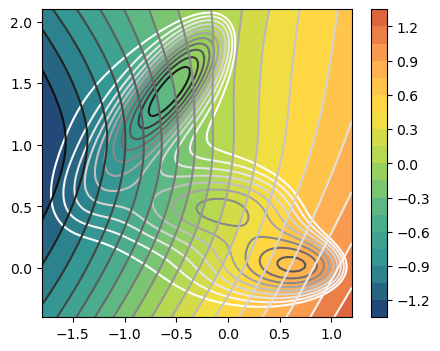

In [39]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=25, ax=ax)
    plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)

CV histogram

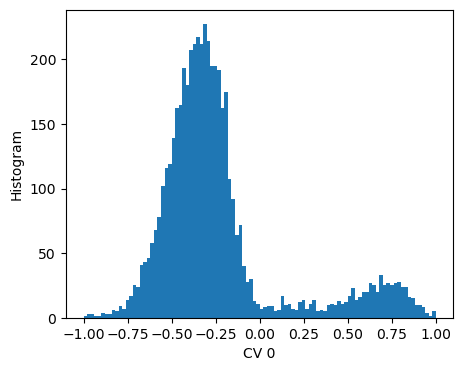

In [40]:
fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

X = dataset[:]['data']
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i,ax in enumerate(axs):
    ax.hist(s[:,i],bins=100)
    ax.set_xlabel(f'CV {i}')
    ax.set_ylabel('Histogram')

Free energy profile

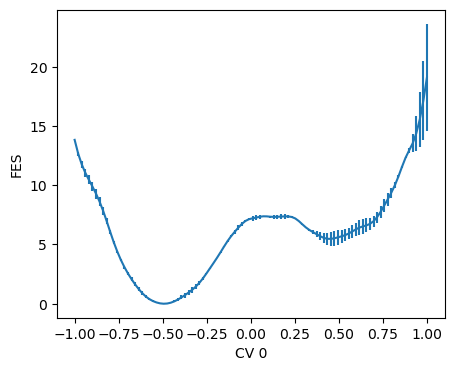

In [31]:
from mlcvs.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

X = dataset[:]['data']
model.eval()
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i,ax in enumerate(axs):
    fes,grid,bounds,std = compute_fes(s[:,i], kbt=2.5, plot=True, scale_by='range', bandwidth=0.02, blocks=2, plot_max_fes=20, ax=ax )
    ax.set_xlabel(f'CV {i}')